In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

import lst

In [2]:
_, n_backround = lst.load("background.lst")

In [3]:
n_backround_avg = np.average(n_backround)
n_backround_std = np.std(n_backround)
print(f"{n_backround_avg=:.3f}, {n_backround_std=:.3f}")

n_backround_avg=19.003, n_backround_std=4.487


In [4]:
t, n = lst.load("measurement.lst")
t = 5 * t
n = n - n_backround_avg

In [5]:
t_max = 55
t_min_fast = 0
t_max_fast = 10
t_min_slow = 15
t_max_slow = 50

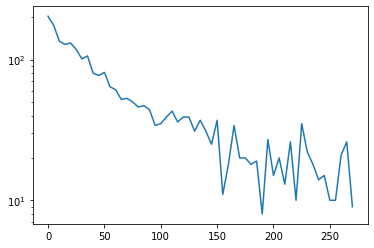

In [6]:
plt.semilogy(t[:t_max], n[:t_max])

## Method 1

In [7]:
k_fast, m_fast = np.polyfit(
    t[t_min_fast:t_max_fast], 
    np.log(n[t_min_fast:t_max_fast]), 
    deg=1
)

print(f"{k_fast=:.4f}, {m_fast=:.3f}")

k_fast=-0.0197, m_fast=5.231


In [8]:
k_slow, m_slow = np.polyfit(
    t[t_min_slow:t_max_slow], 
    np.log(n[t_min_slow:t_max_slow]), 
    deg=1
)

print(f"{k_slow=:.4f}, {m_slow=:.3f}")

k_slow=-0.0070, m_slow=4.341


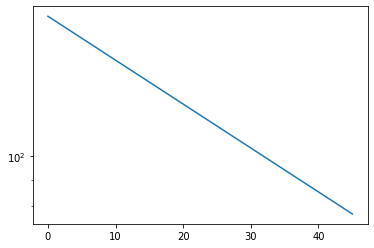

In [9]:
t_fast = 5 * np.arange(t_min_fast, t_max_fast)
n_fast = [np.exp(k_fast*t + m_fast)
          for t in t_fast]

plt.semilogy(t_fast, n_fast)

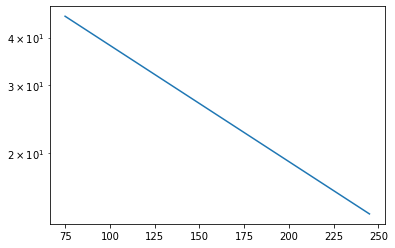

In [10]:
t_slow = 5 * np.arange(t_min_slow, t_max_slow)
n_slow = [np.exp(k_slow*t + m_slow)
          for t in t_slow]

plt.semilogy(t_slow, n_slow)

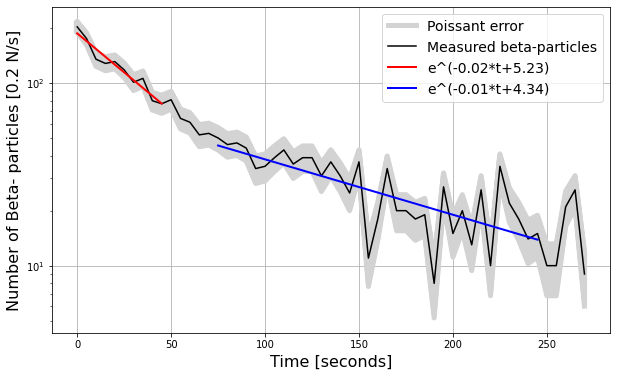

In [52]:
plt.figure(figsize=(10, 6))

# Poissant error
for i in range(-10, 10):
    factor = i / 10
    plt.semilogy(t[:t_max], 
                n[:t_max] + factor * np.sqrt(n[:t_max]),
                color="lightgrey",
                linewidth=5,
                linestyle="-")
plt.semilogy(t[:t_max], 
            n[:t_max] + np.sqrt(n[:t_max]),
            color="lightgrey",
            linewidth=5,
            linestyle="-",
            label="Poissant error") 

# Actual data
plt.semilogy(t[:t_max], 
             n[:t_max],
             color="black",
             label="Measured beta-particles")

plt.semilogy(t_fast,
             n_fast,
             color="red",
             linewidth=2, 
             label=f"e^({k_fast:.2f}*t+{m_fast:.2f})")
plt.semilogy(t_slow, 
             n_slow, 
             color="blue",
             linewidth=2,
             label=f"e^({k_slow:.2f}*t+{m_slow:.2f})")

plt.xlabel("Time [seconds]", fontsize=16)
plt.ylabel("Number of Beta- particles [0.2 N/s]", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()


In [12]:
t_half_fast = - np.log(2) / k_fast
t_half_slow = - np.log(2) / k_slow


def linear_model(t, k, m):
    return k*t + m

_, pcov = curve_fit(linear_model, 
                    t[t_min_fast:t_max_fast], 
                    np.log(n[t_min_fast:t_max_fast]))
k_fast_err, _ = np.sqrt(np.diag(pcov))
t_half_fast_err = np.log(2) * np.abs(1 / (k_fast**2)) * k_fast_err


_, pcov = curve_fit(linear_model, 
                    t[t_min_slow:t_max_slow], 
                    np.log(n[t_min_slow:t_max_slow]))
k_slow_err, _ = np.sqrt(np.diag(pcov))
t_half_slow_err = np.log(2) * np.abs(1 / (k_slow**2)) * k_slow_err


print(f"t_half_fast = {t_half_fast:.1f}s ± {t_half_fast_err:.1f}s")
print(f"t_half_slow = {t_half_slow:.1f}s ± {t_half_slow_err :.1f}s")

t_half_fast = 35.2s ± 3.2s
t_half_slow = 99.3s ± 16.0s


## Method 2

In [13]:
def model(t, n1, tau1, n2, tau2):
    return n1*np.exp(-t/tau1) + n2*np.exp(-t/tau2)

popt, pcov = curve_fit(model, t[:t_max], n[:t_max])

_, tau1_opt, _, tau2_opt = popt
_, tau1_err, _, tau2_err = np.sqrt(np.diag(pcov))

print(f"t_half_1 = {np.log(2)*tau1_opt:.1f}s ± {np.log(2)*tau1_err:.1f}s")
print(f"t_half_2 = {np.log(2)*tau2_opt:.1f}s ± {np.log(2)*tau2_err:.1f}s")


t_half_1 = 21.6s ± 3.5s
t_half_2 = 130.4s ± 36.4s


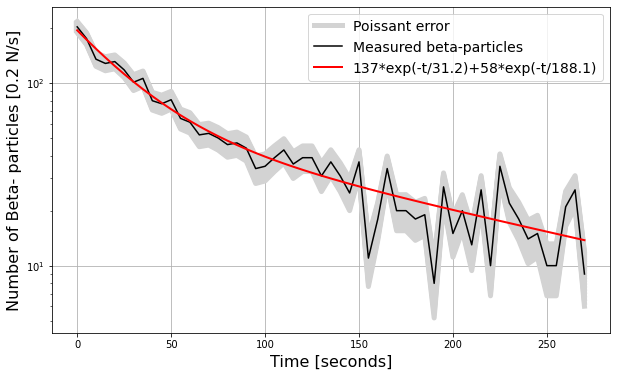

In [51]:
n_fit = model(t[:t_max], *popt)

plt.figure(figsize=(10, 6))

# Poissant error
for i in range(-10, 10):
    factor = i / 10
    plt.semilogy(t[:t_max], 
                n[:t_max] + factor * np.sqrt(n[:t_max]),
                color="lightgrey",
                linewidth=5,
                linestyle="-")
plt.semilogy(t[:t_max], 
            n[:t_max] + np.sqrt(n[:t_max]),
            color="lightgrey",
            linewidth=5,
            linestyle="-",
            label="Poissant error") 

# Actual data
plt.semilogy(t[:t_max], 
             n[:t_max],
             color="black",
             label="Measured beta-particles")

plt.semilogy(t[:t_max],
             n_fit,
             color="red",
             linewidth=2, 
             label=f"{popt[0]:.0f}*exp(-t/{popt[1]:.1f})+{popt[2]:.0f}*exp(-t/{popt[3]:.1f})")

plt.xlabel("Time [seconds]", fontsize=16)
plt.ylabel("Number of Beta- particles [0.2 N/s]", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()